In [2]:
import numpy as np

In [3]:
def hilbert(n):
    return 1.0 /(np.add.outer(np.arange(n), np.arange(n)) + 1)

In [4]:
n = 3
H = hilbert(n)

In [5]:
H[:,0] + H[:, n-1]

array([1.33333333, 0.75      , 0.53333333])

In [6]:
def x_vector(n):
    x = np.zeros(n, dtype=int)
    x[0] = x[-1] = 1   
    x = x.reshape(n,1)
    return x

In [7]:
col = list(range(2,14))
cols = [col]
cols

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]

In [8]:
def cond_inf(A):
    col_sums= []
    for col in A.T:
        col_sums.append(sum(col))
    return max(col_sums)

In [9]:

def lu(matrix: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Führt eine unpivotierte LR-Zerlegung durch (ohne Permutation).
    Gibt (L, R) zurück, so dass R triangular und L Einheitstriangulär ist.
    """
    A = matrix.astype(float).copy()
    n = A.shape[0]
    L = np.eye(n, dtype=float)

    for i in range(n-1):
        for j in range(i+1, n):
            div = A[j, i] / A[i, i]
            A[j, :] -= div * A[i, :]   # ersetzt vector_add + vector_multiply
            L[j, i] = div

    return L, A

def solve_with_lower(b: np.ndarray, L: np.ndarray) -> np.ndarray:
    """
    Vorwärtseinsetzen: L y = b
    """
    n = L.shape[0]
    y = np.zeros_like(b, dtype=float)

    for i in range(n):
        # y[i] = (b[i] - sum(L[i,j]*y[j] für j<i)) / L[i,i]
        y[i] = (b[i] - L[i, :i] @ y[:i]) / L[i, i]

    return y

def solve_with_upper(y: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
    Rückwärtseinsetzen: U x = y
    """
    n = U.shape[0]
    x = np.zeros_like(y, dtype=float)

    for i in range(n-1, -1, -1):
        # x[i] = (y[i] - sum(U[i,j]*x[j] für j>i)) / U[i,i]
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]

    return x

def lu_solve(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Löst A x = b durch eigene LR-Zerlegung + Vorwärts-/Rückwärtseinsetzen.
    """
    L, U = lu(A)
    y = solve_with_lower(b, L)
    x = solve_with_upper(y, U)
    return x

#### a)

In [10]:
from sympy.simplify.simplify import collect_abs


def create_table(n_i):
    cols = []
    for i in range(6):
        col = []
        cols.append(col)

    for n in range(2,n_i+1):
        # Spalte 1
        cols[0].append(n)

        # Spalte 2
        A = hilbert(n)
        cols[1].append(float(cond_inf(A)))


        # Spalte 3
        x = x_vector(n)
        x_bs = np.linalg.solve(A, x)
        rel_mistake = cond_inf(x-x_bs) / cond_inf(x)
        cols[2].append(float(rel_mistake))

        # Spalte 4
        x_lr = lu_solve(A, x)
        rel_mistake = cond_inf(x-x_lr) / cond_inf(x)
        cols[3].append(float(rel_mistake))

        # Spalte 5
        R = np.linalg.cholesky(A).T
        V = R.T
        y = solve_with_lower(x, V)
        x_chol = solve_with_upper(y, R)
        rel_mistake = cond_inf(x-x_chol) / cond_inf(x)
        cols[4].append(float(rel_mistake))

        # Spalte 6
        diff = A*x_chol - A*x
        rel_mistake = cond_inf(diff)
        cols[5].append(float(rel_mistake))
    return cols

In [11]:
def display_table(cols):
    index = "Index"
    c1 = "Kondi.Z. inf-Norm A"
    c2 = "Kondi.Z. inf-Norm bs"
    c3 = "Kondi.Z. inf-Norm lr"
    c4 = "Kondi.Z. inf-Norm ch"
    c5 = "Kondi.Z. inf-Norm rev"
    print(f"{index:<6}|{c1:<23}|{c2:<23}|{c3:<23}|{c4:<23}|{c5:<23}|")
    for i in range(len(cols[0])):
        print(f"{cols[0][i]:6.0f}", end="|")
        for j in range(1, len(cols)):
            print(f"{cols[j][i]:23.4f}", end="|")
        print(" ")


In [12]:
display_table(create_table(13))
print("\n \n \n")
display_table(create_table(14))
print("\n \n \n")
display_table(create_table(15))

Index |Kondi.Z. inf-Norm A    |Kondi.Z. inf-Norm bs   |Kondi.Z. inf-Norm lr   |Kondi.Z. inf-Norm ch   |Kondi.Z. inf-Norm rev  |
     2|                 1.5000|                -1.0000|                -1.0000|                -1.0000|                 0.1667| 
     3|                 1.8333|               -15.5000|               -15.5000|               -15.5000|                 0.4667| 
     4|                 2.0833|               -67.0000|               -67.0000|               -67.0000|                 0.6071| 
     5|                 2.2833|              -316.5000|              -316.5000|              -316.5000|                 0.6889| 
     6|                 2.4500|             -1382.0000|             -1382.0000|             -1382.0000|                 0.7424| 
     7|                 2.5929|             -6008.5000|             -6008.5000|             -6008.5000|                 0.7802| 
     8|                 2.7179|            -25735.0005|            -25734.9999|            -25735.

LinAlgError: Matrix is not positive definite

In [ ]:
# Bis n = 8 lässt sich kein Unterschied im Fehler zwischen den Lösungmethoden sehen. 
# Ab 8 kann man sehen, dass die LR Methode einen kleineren Fehler liefert. 
# Ab n = 14 ist die Hilbert Matrix nicht mehr positiv definit und ich erhalte einen Error. 

#### b)

In [32]:
def tridiagoinales(a,b,f):
    c,d = [],[]
    for i, a_i in enumerate(a):
        if i - 1 >= 0:
            c_i = np.sqrt(a_i - d[i-1]**2)
        else:
            c_i = np.sqrt(a_i)
        c.append(c_i)
        if i < len(b):
            d_i = b[i]/c_i
            d.append(d_i)

    y = []
    y.append(f[0]/c[0])
    for i in range(1, len(f)):
        y.append((f[i] - d[i-1]*y[i-1])/c[i])

    n = len(y)
    u = np.zeros(n)
    u[-1] = (y[-1]/c[-1])

    for i in range(-2, -n-1, -1):
        u[i] = ((y[i] - d[i+1]*u[i+1])/c[i])        
    return u

for n in range(2,5):
    s, f = np.ones(n), np.ones(n)
    a = s*2
    a = np.append(a, 1)
    b = s*(-1)
    s = np.append(s, 1)
    f = np.append(f, 1)
    u = tridiagoinales(a,b,f)
    print("n:", n + 1,"   u:", u)

n: 3    u: [3. 5. 6.]
n: 4    u: [ 4.  7.  9. 10.]
n: 5    u: [ 5.  9. 12. 14. 15.]


Der Zusammenhang zwischen n und u_i stellt sich als u_i = ((2*n +1)*i - i**2)/2 dar. 
Allerding konnte ich diesen Zusammenhang nicht selbst ermitteln sondern musste ihn aus externen Quellen beziehen. 

#### c)

In [38]:
import matplotlib.pyplot as plt

In [48]:
def getfreshkreisundente():
    ente = [
    [0, 1, 1  , 1.5, 2.5, 3  , 3  , 4  , 2  , 2  , 1  , -3.7, -5, -4, -3, 0],
    [1, 0, 3.5, 4  , 4  , 3.5, 3  , 3  , 2  , -1 , -2 , -2  , 1 , 0  ,1  ,1]
    ]
    ente = np.array(ente)

    kreis = [
    [6*np.cos(2*np.pi * a/1000) for a in range(1000)],
    [6*np.sin(2*np.pi * a/1000) for a in range(1000)]
    ]
    kreis = np.array(kreis)
    return ente, kreis

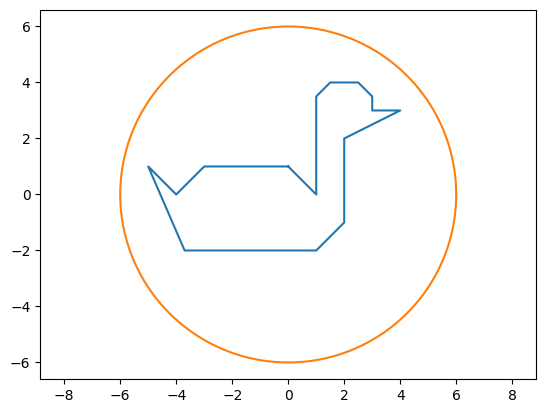

In [ ]:
ente, kreis = getfreshkreisundente()

plt.figure()
plt.axis('equal')
plt.plot(ente[0], ente[1])
plt.plot(kreis[0], kreis[1])
plt.show()

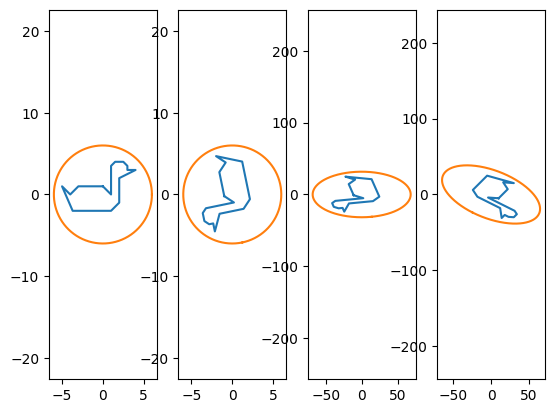

In [61]:
import random as r
A = [
[r.randint(-10, 10),r.randint(-10, 10)],
[r.randint(-10, 10),r.randint(-10, 10)] 
]
U,S,V = np.linalg.svd(A, full_matrices=True)

plt.figure()

plt.subplot(1,4,1)
plt.axis('equal')
plt.plot(ente[0], ente[1])
plt.plot(kreis[0], kreis[1])

plt.subplot(1,4,2)
plt.axis('equal')
ente_2 = V@ente
kreis_2 = V@kreis
plt.plot(ente_2[0], ente_2[1])
plt.plot(kreis_2[0], kreis_2[1])

plt.subplot(1,4,3)
plt.axis('equal')
Sigma = np.diag(S)
ente_3 = Sigma@ente_2
kreis_3 = Sigma@kreis_2
plt.plot(ente_3[0], ente_3[1])
plt.plot(kreis_3[0], kreis_3[1])

plt.subplot(1,4,4)
plt.axis('equal')
ente_4 = A@ente
kreis_4 = A@kreis
plt.plot(ente_4[0], ente_4[1])
plt.plot(kreis_4[0], kreis_4[1])
plt.show()